### 导入一些需要用到的库

In [1]:
import tushare as ts
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

### 获取某股票最近若干天的前复权数据

In [ ]:
def get_data(code,end='2018-01-01', duration=365):
    
    # 打印股票的基本信息
    df = ts.get_stock_basics()
    print(df.loc[code][['name', 'industry', 'timeToMarket']])
    
    d1 = datetime.datetime.strptime(end,'%Y-%m-%d')
    d2 = d1 - datetime.timedelta(days=duration)
    start = d2.strftime('%Y-%m-%d')

    return ts.get_h_data(code, start=start, end=end)

### 一个例子 -- 获取数据，保存文件，可视化

In [ ]:
code = '300222'

data = get_data(code)

In [ ]:
data.to_csv('stock_data.csv')

In [2]:
data = pd.read_csv('stock_data.csv')

In [3]:
data.set_index(["date"], inplace=True)

data_sorted = data.sort_index()

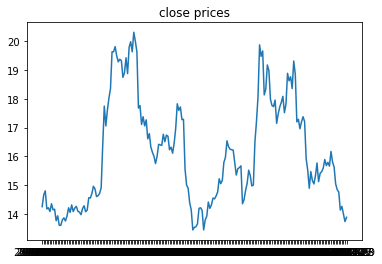

In [4]:
plt.plot(data_sorted.close)
plt.title('close prices')
plt.show()

### 将数据集分割为训练集和测试集

In [5]:
def train_test_split(data,SEQ_LENGTH = 25,test_prop=0.3):
    
    ntrain = int(len(data) *(1-test_prop))  # len(data) = 197
    predictors = data.columns[:4]  # open, high, close, low
    data_pred = data[predictors]
    num_attr = data_pred.shape[1]  # 4
    
    result = np.empty((len(data) - SEQ_LENGTH, SEQ_LENGTH, num_attr))
    y = np.empty((len(data) - SEQ_LENGTH, SEQ_LENGTH))
    yopen = np.empty((len(data) - SEQ_LENGTH, SEQ_LENGTH))

    for index in range(len(data) - SEQ_LENGTH):
        result[index, :, :] = data_pred[index: index + SEQ_LENGTH]
        y[index, :] = data_pred[index+1: index + SEQ_LENGTH + 1].close
        yopen[index, :] = data_pred[index+1: index + SEQ_LENGTH + 1].open

    """
        xtrain的大小：ntrain x SEQ_LENGTH x 4
        ytrain的大小：ntrain x SEQ_LENGTH
        
        * xtrain的每个batch为长为SEQ_LENGTH的连续序列，一共有ntrain个batch，
          序列中每个单元都是一个四元组（open，high，close，low）
        * ytrain的每个batch为长为SEQ_LENGTH的连续序列，一共有ntrain个batch，
          序列中每个单元是xtrain中对应四元组所在日期的下一天的close price
        
        xtest 的大小：    ntest x SEQ_LENGTH x 4                
        ytest的大小：     ntest x SEQ_LENGTH      (close price)
        ytest_open的大小：ntest x SEQ_LENGTH      (open price)  
        
        * xtest的每个batch为长为SEQ_LENGTH的连续序列，一共有ntest个batch，
          序列中每个单元都是一个四元组（open，high，close，low）
          每一个序列仅包含一个新四元组，且在最后一个
        * ytest的每个batch为长为SEQ_LENGTH的连续序列，一共有ntest个batch，
          序列中每个单元是xtest中对应四元组所在日期的下一天的close price
        
        类型：numpy.ndarray
    """
    xtrain = result[:ntrain, :, :]
    ytrain = y[:ntrain]
    
    xtest = result[ntrain:, :, :]
    ytest = y[ntrain:]
    ytest_open = yopen[ntrain:]
    
    return xtrain, xtest, ytrain, ytest, ytest_open

In [6]:
xtrain, xtest, ytrain, ytest, ytest_open = train_test_split(data_sorted)

# 转为tensor
xtrain = torch.from_numpy(xtrain)
ytrain = torch.from_numpy(ytrain)

xtest = torch.from_numpy(xtest)
ytest = torch.from_numpy(ytest)

In [7]:
xtrain.shape

torch.Size([137, 25, 4])

In [8]:
ytrain.shape

torch.Size([137, 25])

In [9]:
xtest.shape

torch.Size([35, 25, 4])

In [10]:
ytest.shape

torch.Size([35, 25])

### 定义LSTM模型

In [11]:
class lstm(nn.Module):
    def __init__(self, input_size=4, hidden_size=30, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # 使用两层LSTMCell堆积来提高模型表达力
        self.layer1 = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size)
        self.layer2 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
        
    def forward(self, input_data, future=0):
        outputs = []
        
        # LSTM cell的三个输入：input(batch,input_size), h_0(batch,hidden_size), c_0(batch,hidden_size)
        # batch即为input_data中样本的数量，即为ntrain
        # 此处input_data的大小为：ntrain x SEQ_LENGTH X 4
        
        # init hidden states and cell state for layer1
        h_t = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        c_t = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        
        # init hidden states and cell state for layer2
        h_t2 = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        c_t2 = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        
        # input_data:[ntrain x SEQ_LENGTH X 4]
        # chunk将tensor按第二个维度分成 SEQ_LENGTH 块
        for i, input_t in enumerate(input_data.chunk(input_data.size(1), dim=1)):
            
            # reshape: [ntrain x 1 x 4] => [ntrain x 4] 
            input_t = input_t.squeeze(1)
            
            # 每个input_t是 ntrain x 4 的tensor， batch=ntrain，input_size=4
            h_t, c_t = self.layer1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.layer2(h_t, (h_t2, c_t2))
            
            # output的大小为 ntrainx1
            output = self.linear(h_t2)
            outputs += [output]
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        
        return outputs

### 训练LSTM模型

In [12]:
# 设置随机数种子
np.random.seed(0)
torch.manual_seed(0)

# 构建网络
lstm = lstm().double()
criterion = nn.MSELoss()

# 优化器
optimizer = optim.LBFGS(lstm.parameters(), lr=0.2)

# 开始训练    
for i in range(50):
    print('STEP: ', i)
    
    def closure():
        optimizer.zero_grad()
        out = lstm(xtrain)
        
        loss = criterion(out, ytrain)
        print('loss:', loss.item())
        loss.backward()
        return loss
    
    optimizer.step(closure)

STEP:  0
loss: 266.5290607910203
loss: 265.934310773996
loss: 67.883962971809
loss: 5.683700752817894
loss: 5.198368139878013
loss: 4.963806308784235
loss: 4.806668337551597
loss: 4.696169416019739
loss: 4.6141229645733635
loss: 4.549646659461979
loss: 4.496059006157293
loss: 4.448708921290161
loss: 4.403499098160631
loss: 4.355851099155021
loss: 4.299166984807873
loss: 4.21962771957382
loss: 4.078914954607526
loss: 3.9022377501339807
loss: 3.871836558999246
loss: 3.855356188079046
STEP:  1
loss: 3.8020267627173134
loss: 3.7594716973142517
loss: 3.716365444003469
loss: 3.6707875462369883
loss: 3.616033378049999
loss: 3.520591498986461
loss: 3.5035582115446373
loss: 3.4798978610164255
loss: 3.462737276167632
loss: 3.4392369043663487
loss: 3.40679605646652
loss: 3.382016793139969
loss: 3.3757641192548444
loss: 3.366816488238791
loss: 3.3525107008373336
loss: 3.3364750978881625
loss: 3.3211824461630703
loss: 3.3078123611606474
loss: 3.2940706446125967
loss: 3.2780705071849208
STEP:  2
los

loss: 0.24753301671187095
loss: 0.2469236415166722
loss: 0.24614187718509759
loss: 0.2453595162823143
loss: 0.24469731770221104
loss: 0.24435526790508172
loss: 0.24393828566998013
loss: 0.2434751103045279
loss: 0.24301427620800645
loss: 0.24260371254507226
loss: 0.24213093536564828
loss: 0.24159598933364163
loss: 0.2410331861099708
loss: 0.2405675986457724
loss: 0.2400080610407681
loss: 0.2394971476684496
loss: 0.23909406042121148
loss: 0.23874464215767394
STEP:  17
loss: 0.23839016047941047
loss: 0.23801218586626996
loss: 0.2377043987377328
loss: 0.23741514501594319
loss: 0.23715547453228794
loss: 0.23690201534132704
loss: 0.23664692752593494
loss: 0.23637819501923607
loss: 0.23607125471220394
loss: 0.2358915810607451
loss: 0.2356709898674708
loss: 0.23540092607103735
loss: 0.23509276543661267
loss: 0.23474270575311368
loss: 0.2343477007543102
loss: 0.2339097607786873
loss: 0.23344487410210277
loss: 0.23294768485623046
loss: 0.23246266201834825
loss: 0.23196921555193706
STEP:  18
loss

loss: 0.16915336410872708
loss: 0.169040184749395
loss: 0.1689184976095012
loss: 0.16880685099795167
STEP:  32
loss: 0.16870782949829466
loss: 0.16862775335341526
loss: 0.16855257091235473
loss: 0.1684990653359272
loss: 0.1684476014628917
loss: 0.1684022512412425
loss: 0.16837062353543247
loss: 0.1683397331310126
loss: 0.16831060745478085
loss: 0.1682818792074044
loss: 0.1682539708067194
loss: 0.16822586837255718
loss: 0.168197837056344
loss: 0.16816886398563877
loss: 0.16813883738758914
loss: 0.16810464476717363
loss: 0.16806719760440075
loss: 0.168020776437224
loss: 0.16796383523868216
loss: 0.16782651766060264
STEP:  33
loss: 0.16777832078303073
loss: 0.16772067993517736
loss: 0.16766636016754174
loss: 0.16761071840811834
loss: 0.1675347799437019
loss: 0.16743246594204342
loss: 0.16731190485320113
loss: 0.1672273644204868
loss: 0.1671511055374419
loss: 0.16708791297367132
loss: 0.16701423187462858
loss: 0.16698057733975324
loss: 0.1669493753562051
loss: 0.1678173448660722
loss: 0.16

loss: 0.15134037809218365
loss: 0.1513829695462497
loss: 0.15134467240874172
loss: 0.1513073500638046
loss: 0.1512716012082602
loss: 0.15124494166801833
loss: 0.15122320278417145
loss: 0.15120001637652425
STEP:  48
loss: 0.15117586753861387
loss: 0.15114957621655675
loss: 0.15112217546907067
loss: 0.15109130459592324
loss: 0.15105949813204728
loss: 0.1510180358685119
loss: 0.15098482308277403
loss: 0.15094403407254434
loss: 0.15090406454642755
loss: 0.15085044943449943
loss: 0.15078818385976053
loss: 0.1506894641730435
loss: 0.15062860922712357
loss: 0.1505523480275073
loss: 0.1504813643775501
loss: 0.15041099647452294
loss: 0.15031744564882757
loss: 0.1502265354054873
loss: 0.15014868797033942
loss: 0.15008056467490177
STEP:  49
loss: 0.15002082983158943
loss: 0.1499680267081172
loss: 0.1499215738696619
loss: 0.1498899969804817
loss: 0.14985876241213708
loss: 0.14982746842453604
loss: 0.14979789153274833
loss: 0.1497704800534931
loss: 0.14974583395943555
loss: 0.14972320106359294
loss

### 测试LSTM模型

In [13]:
with torch.no_grad():
    future = 0
    pred = lstm(xtest, future=future)
    loss = criterion(ytest, pred)
    print('test loss:', loss.item())

pred_data = pred.detach().numpy()
test_data = ytest.detach().numpy()

test loss: 0.4475557709978269


In [14]:
# 从每个batch的序列数据中提取出ground truth和预测值

gd_truth = []
pred_val = []

# 每个batch的序列数据中的最后一个是新来的数据，将每个batch中新来的值提取出来
for i in range(len(pred_data)):
    gd_truth.append(test_data[i][-1])
    pred_val.append(pred_data[i][-1])
    
gd_truth = np.array(gd_truth)
pred_val = np.array(pred_val)

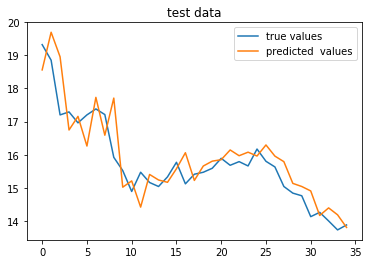

In [15]:
plt.plot(gd_truth, label='true values')
plt.plot(pred_val, label='predicted  values')
plt.legend()
plt.title('test data')
plt.show()